In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
import scipy
import pickle
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import seaborn as sns
import sigpy as sp
import cupy as cp
import numpy as np
from sigpy.mri.app import TotalVariationRecon, L1WaveletRecon
from scipy.io import savemat

## My files
from plot_helpers import *
import raw_data_utils
from raw_resp_signal_utils import *
from pca_helper import pca_resp_signal

### Load data

Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:13<00:00, 1.25GB/s]


Full number of partitions = 72
ksp_data.shape = (15, 58, 2002, 256)
Average value, slices vs samples per gate = 1.0259317605232354e-05
Average value, readouts vs spokes per gate = 6.189437499415362e-06
Average value, slices vs center sample per gate = 5.0106042181141675e-05


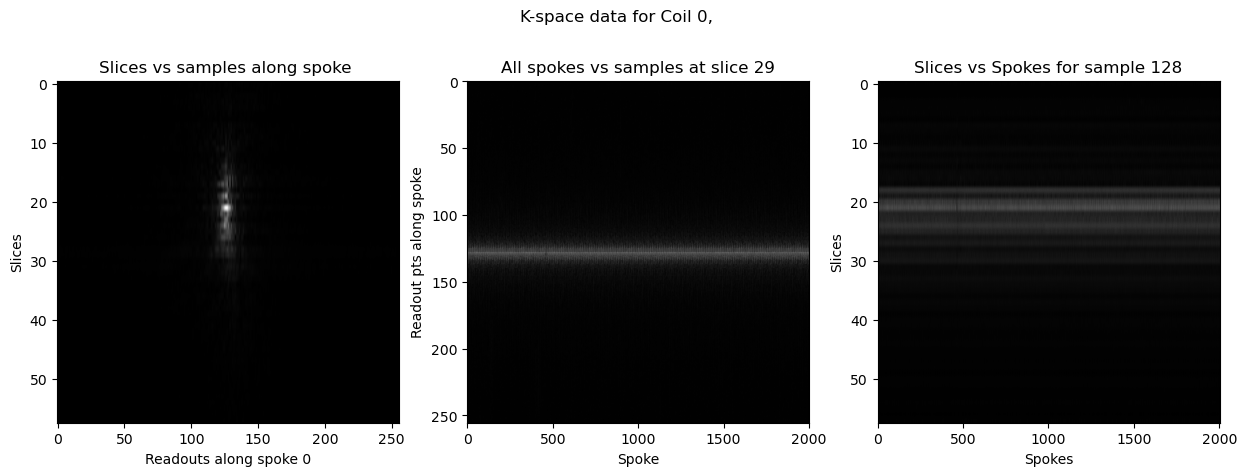

In [2]:
data_file_pt4 = '/home/lilianae/data/lilianae/NaF_Patient4/anon_meas_MID00062_FID67913_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS_Qfatsat.dat'

multi_twix, mapped, ksp_data = raw_data_utils.get_kspace_data(data_file_pt4)
fig, axs = plot_ksp_data_multichannel(ksp_data=ksp_data, coil_idx=0)

### 1. Get timestamps from k-space

In [3]:
chronological_data = raw_data_utils.get_chronological_data_points(multi_twix=multi_twix)

In [4]:
sorted_chronological_data = raw_data_utils.sort_data_chronological(chronological_data)

In [5]:
raw_data_utils.check_chronological_data(sorted_chronological_data)


First 10 data points (chronological order):
  Time 0: Par=0, Lin=0, Timestamp=21604187
  Time 1: Par=2, Lin=0, Timestamp=21604190
  Time 2: Par=3, Lin=0, Timestamp=21604192
  Time 3: Par=4, Lin=0, Timestamp=21604194
  Time 4: Par=7, Lin=0, Timestamp=21604197
  Time 5: Par=8, Lin=0, Timestamp=21604199
  Time 6: Par=9, Lin=0, Timestamp=21604202
  Time 7: Par=10, Lin=0, Timestamp=21604204
  Time 8: Par=11, Lin=0, Timestamp=21604206
  Time 9: Par=14, Lin=0, Timestamp=21604209


### 2. Get resp signal from timestamps

In [6]:
def extract_respiratory_signal_all_slices(sorted_chronological_data, start_sample_idx, end_sample_idx, verbose=True):
    '''

    Extract respiratory signal based on chronological data ordering (Only using center partition)

    Inputs
    ---------------------------
    sorted_chronological_data: dict
        Dictionary with keys: 'timestamp', 'partition', 'line', 'kspace_data', 'acquisition_index'. Each k-space line is in dictionary, and timestamps should be in ascending order.

    start_sample_idx: int
        Starting sample idx for which to calculate signal mean

    end_sample_idx: int
        End sample idx for which to calculate signal mean

    Outputs
    ---------------------------
    respiratory_signal_chronological: ndarray
        Resiratory signal of shape (temporal points, num_channels)

    timestamps_chronological: ndarray
        Chronological timestamps in physical seconds
    '''
    respiratory_signal_chronological = []
    timestamps_chronological = []
    for data_point in sorted_chronological_data:
        kspace_data = data_point['kspace_data']
        timestamp = data_point['timestamp']
        partition = data_point['partition']

        ## Calculate DC component for each channel
        ## Use samples around k-space center (128), but use wider window to capture motion
        dc_components = np.mean(np.abs(kspace_data[:, start_sample_idx:end_sample_idx]), axis=-1)  # Shape: (channels,)
        
        respiratory_signal_chronological.append(dc_components)
        timestamps_chronological.append(timestamp)

    ## Convert to arrays
    respiratory_signal_chronological = np.array(respiratory_signal_chronological)  # Shape: (time_points, channels)
    timestamps_chronological = np.array(timestamps_chronological)*(2.5e-3)           ## Convert timesteps into actual seconds
    if verbose:
        print(f'len(timestamps_chronological) = {len(timestamps_chronological)}')
        print(f"Respiratory signal shape: {respiratory_signal_chronological.shape}")
        print(f"Time range: {timestamps_chronological[0]} to {timestamps_chronological[-1]}")

    return respiratory_signal_chronological, timestamps_chronological

In [7]:
raw_resp_signal, timestamps_chronological = extract_respiratory_signal_all_slices(sorted_chronological_data, start_sample_idx=120, end_sample_idx=150)


print(f'First 10 chronological timestamps: ')
for i in range(10):
        print(f'Timestamp {i} = {timestamps_chronological[i]}')

len(timestamps_chronological) = 116116
Respiratory signal shape: (116116, 15)
Time range: 54010.4675 to 54761.89
First 10 chronological timestamps: 
Timestamp 0 = 54010.4675
Timestamp 1 = 54010.475
Timestamp 2 = 54010.48
Timestamp 3 = 54010.485
Timestamp 4 = 54010.4925
Timestamp 5 = 54010.4975
Timestamp 6 = 54010.505000000005
Timestamp 7 = 54010.51
Timestamp 8 = 54010.515
Timestamp 9 = 54010.5225


In [22]:
time_axis_seconds, scan_duration, median_tr, effective_fs =calc_scan_duration_and_TR(timestamps_chronological)
TR = 0.006
print(1/TR)

Scan duration: 751.4 seconds (12.5 minutes)
Median TR from chronological data: 0.005000 seconds
Effective sampling frequency: 200.000 Hz
166.66666666666666


In [23]:
filtered_resp_signals = lowpass_filter_resp_signal(raw_resp_signal, 
                                                   cutoff_hz=0.25,
                                                   fs_hz = 1/(TR), 
                                                   order= 2)

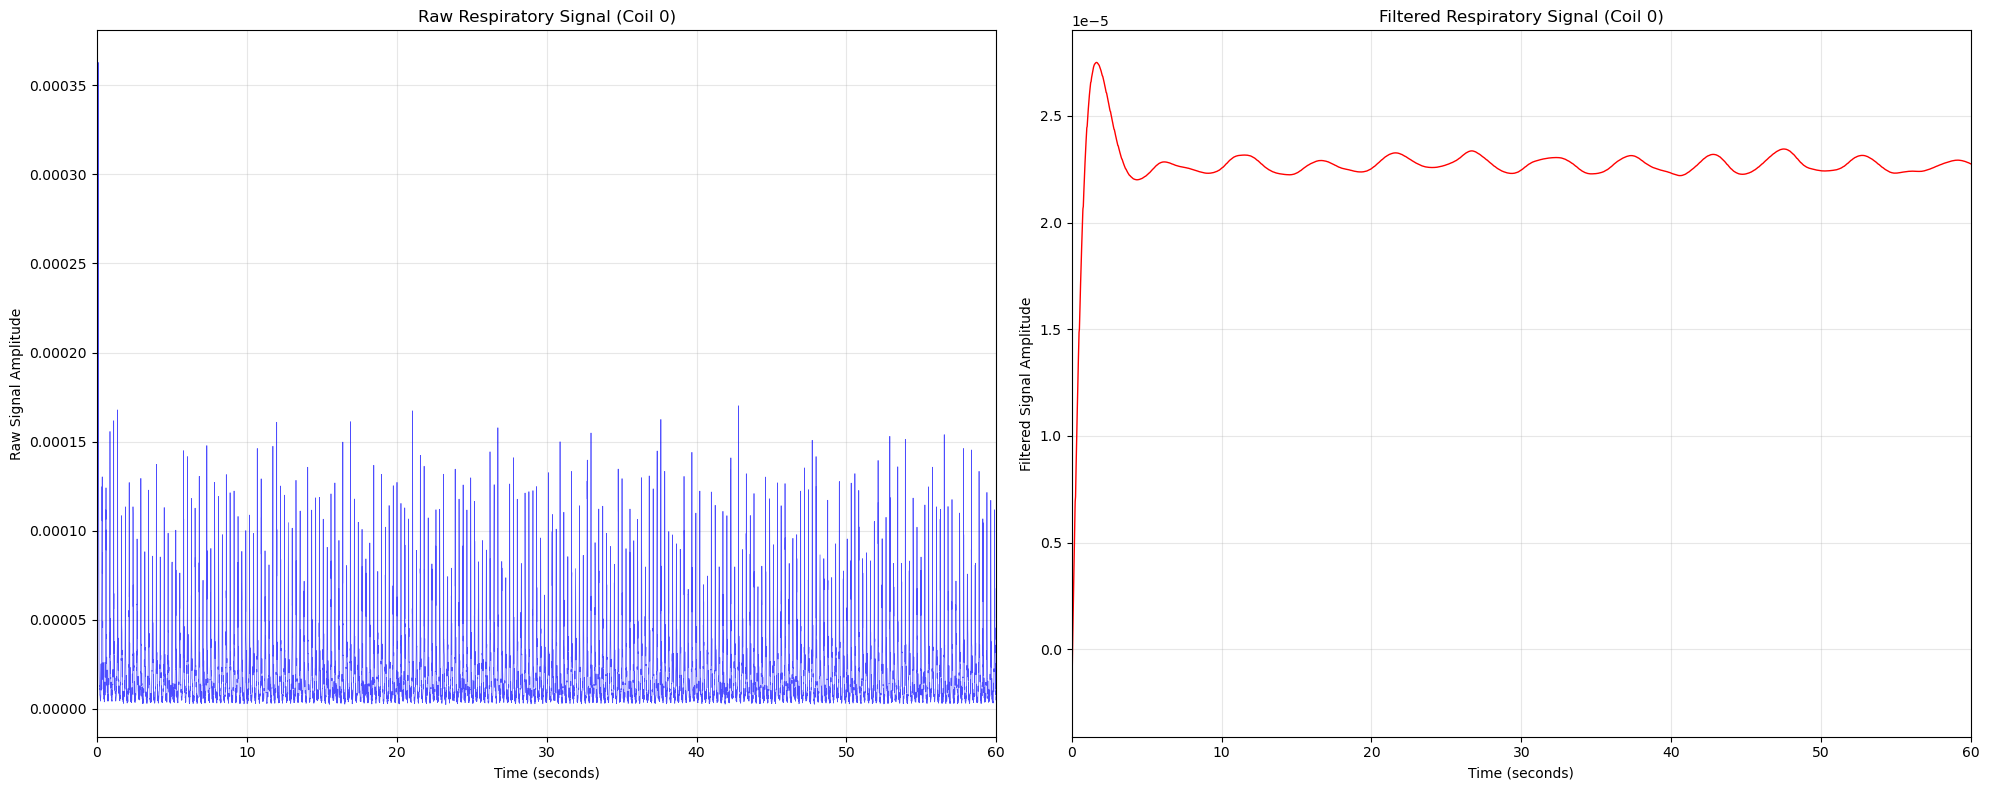

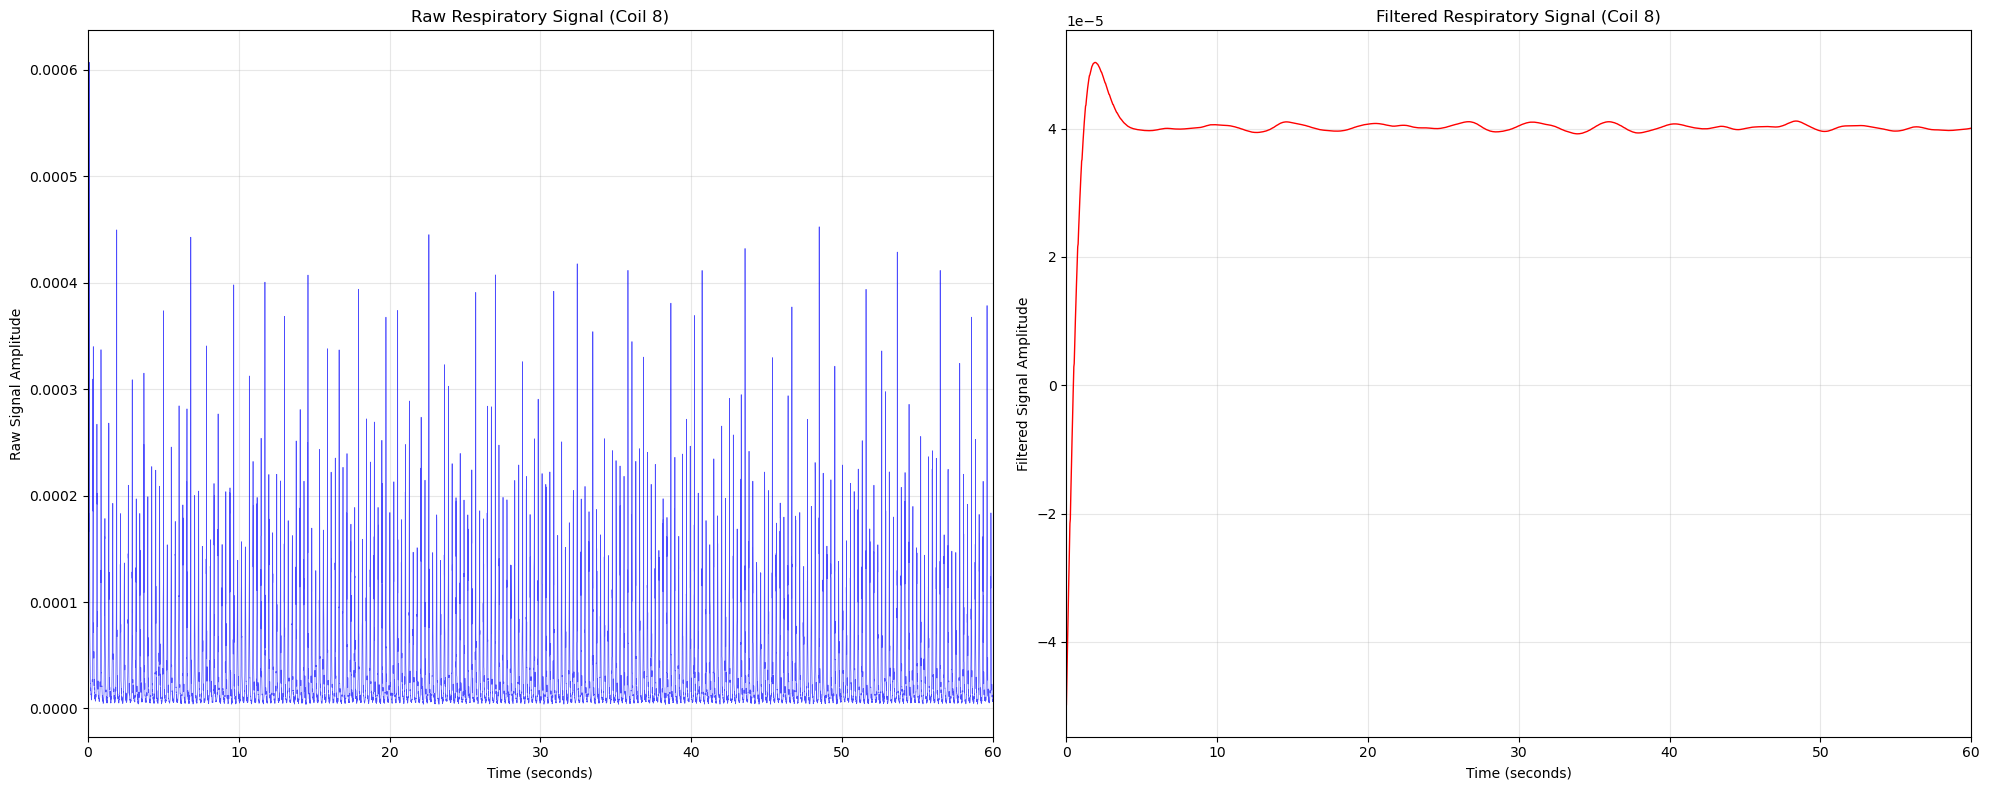

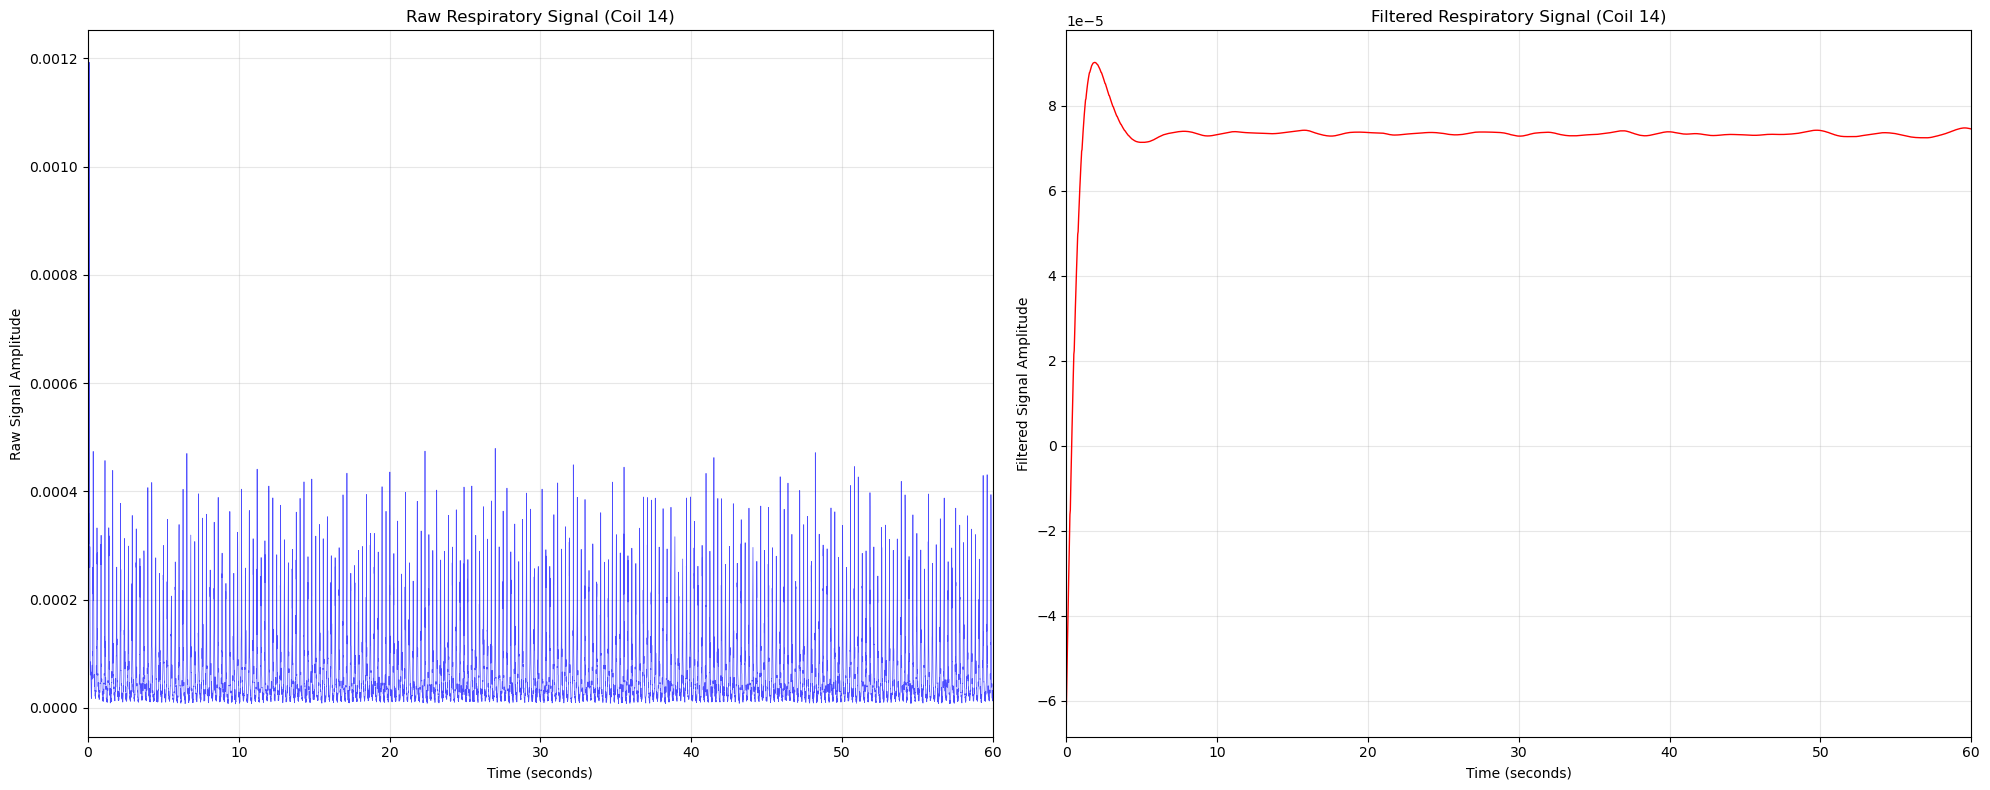

In [24]:
coil_indices = [0, 8, 14]

plot_raw_and_filtered_signal(time_axis_seconds, raw_resp_signal, filtered_resp_signals, coil_indices)

In [25]:
resp_signal_pca = pca_resp_signal(filtered_resp_signals, n_components=3)

Final respiratory signal shape: (116116,)
PCA explained variance ratio: 0.924


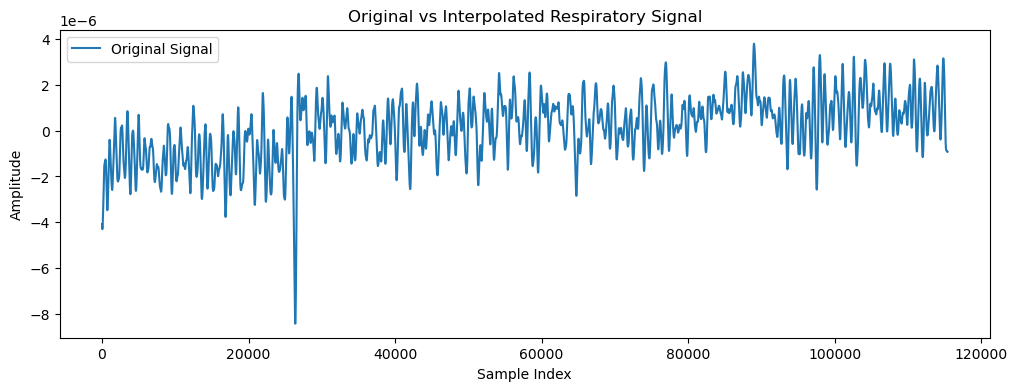

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(resp_signal_pca[700:], label='Original Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Interpolated Respiratory Signal')
plt.show()

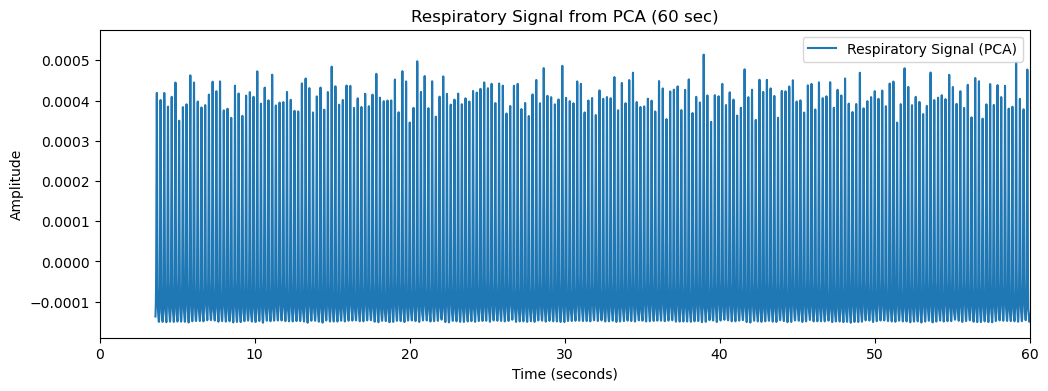

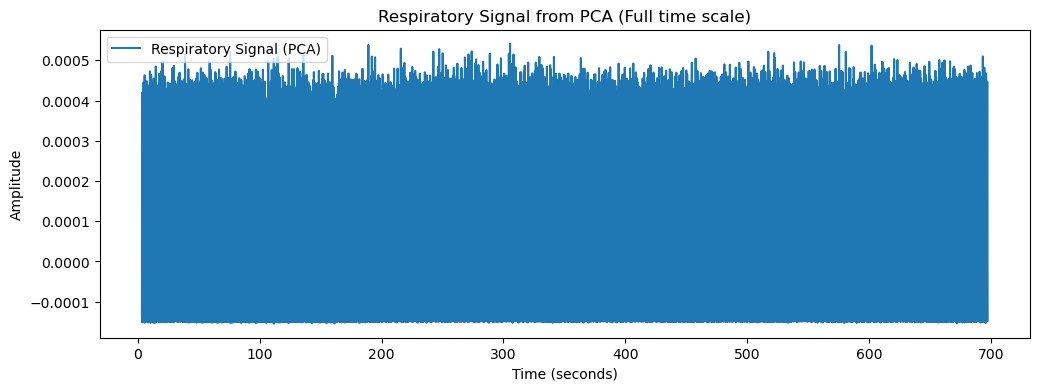

In [21]:
def plot_resp_signal(time_ms, resp_signal, TR, samples_to_discard=0, xlim=True, output_dir_figs=None):
    n_samples = len(resp_signal)
    time_ms = np.arange(n_samples) * TR
    plt.figure(figsize=(12, 4))
    plt.plot(time_ms[samples_to_discard:], resp_signal[samples_to_discard:], label="Respiratory Signal (PCA)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    if output_dir_figs is None:
        output_dir_figs = Path.cwd()

    if xlim:
        plt.xlim(0, 60)
        plt.title("Respiratory Signal from PCA (60 sec)")
        # plt.savefig(output_dir_figs/'resp_pca_one_min')
    else:
        plt.title("Respiratory Signal from PCA (Full time scale)")
        # plt.savefig(output_dir_figs/'resp_pca_full_time')
    plt.show()

plot_resp_signal(time_axis_seconds, resp_signal_pca, TR, samples_to_discard=600)
plot_resp_signal(time_axis_seconds, resp_signal_pca, TR, samples_to_discard=600, xlim=False)

In [13]:
# Check the full pattern for line 0
line_0_partitions = []
for i in range(len(chronological_data)):
    if chronological_data[i]['line'] == 0:
        line_0_partitions.append(chronological_data[i]['partition'])
    if len(line_0_partitions) >= 58:  # Stop after we've seen all partitions once
        break

print(f"Partition order for line 0: {line_0_partitions}")
print(f"Number of unique partitions: {len(set(line_0_partitions))}")

# Also check when line 1 starts
for i in range(len(chronological_data)):
    if chronological_data[i]['line'] == 1:
        print(f"Line 1 starts at acquisition {i}, partition {chronological_data[i]['partition']}")
        break

Partition order for line 0: [0, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19, 21, 22, 24, 25, 26, 28, 29, 31, 32, 33, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 49, 50, 53, 54, 55, 56, 1, 5, 12, 13, 18, 20, 23, 27, 30, 34, 35, 40, 44, 46, 51, 57, 6, 52]
Number of unique partitions: 58
Line 1 starts at acquisition 41, partition 2


In [ ]:
import numpy as np

def amplitude_base_gating(num_gates, resp_signal_trim):
    '''Perform amplitude based gating
    '''
    percentiles = np.linspace(0, 100, num_gates + 1)
    thresholds = np.percentile(resp_signal_trim, percentiles[1:-1])
    gate_idx = np.digitize(resp_signal_trim, thresholds) + 1  # 1 to num_gates
    return gate_idx

def count_acquisitions_per_gate(num_gates, gate_idx):
    for gate in range(1, num_gates + 1):
        count = np.sum(gate_idx == gate)
        print(f"  Gate {gate}: {count} acquisitions ({100*count/len(gate_idx):.1f}%)")

def generate_ga_coords(num_partitions, num_spokes, num_samples):
    img_shape = (num_partitions, num_samples, num_samples)
    return golden_angle_coords_3d(img_shape, num_spokes, num_samples)

def sort_data_by_gate(chronological_data, coords_all, gate_idx, acquisitions_to_keep, num_acquisitions, num_partitions):
    # Create full gate assignment array (0 for discarded, 1-num_gates for kept)
    gate_assignments = np.zeros(num_acquisitions, dtype=int)
    num_gates = np.max(gate_idx)
    gate_assignments[acquisitions_to_keep] = gate_idx
    gate_partition_line_data = [[{} for _ in range(num_partitions)] for _ in range(num_gates)]
    
    for i, data_point in enumerate(chronological_data):
        gate = gate_assignments[i]
        
        if gate == 0:  # Discarded acquisition
            continue
        
        partition = data_point['partition']
        line = data_point['line']
        kspace_data = data_point['kspace_data']  # Shape: (num_coils, num_samples)
        
        # Store this acquisition in the appropriate gate
        gate_idx = gate - 1  # Convert to 0-indexed
        
        # Store k-space data and coordinates
        if line not in gate_partition_line_data[gate_idx][partition]:
            gate_partition_line_data[gate_idx][partition][line] = {
                'kspace': kspace_data,
                'coords': coords_all[partition, line, :, :]
            }

    return gate_partition_line_data, gate_assignments

def organize_gated_data(gate_partition_line_data, num_coils, num_partitions, num_samples, num_gates, verbose):
    # Strategy: For each gate, collect all (partition, line) pairs that were actually acquired
    # Then organize them sequentially, creating a new "spoke index" for each gate
        # Initialize arrays for gated data
    data_bins = []
    spoke_bins = []

    if verbose:
        print("\nOrganizing gated data into dense arrays...")

    for gate_idx in range(num_gates):
        partition_line_pairs = []
        for partition in range(num_partitions):
            for line in sorted(gate_partition_line_data[gate_idx][partition].keys()):
                partition_line_pairs.append((partition, line))
        
        num_acquisitions_in_gate = len(partition_line_pairs)
        
        # Initialize arrays for this gate
        # Shape: (coils, num_acquisitions, num_samples) - treating each acquisition as a separate "spoke"
        gate_kspace = np.zeros((num_coils, num_acquisitions_in_gate, num_samples), 
                               dtype=np.complex64)
        gate_coords = np.zeros((num_acquisitions_in_gate, num_samples, 3), 
                               dtype=np.float32)
        
        # Fill in data using new sequential indexing
        for new_spoke_idx, (partition, line) in enumerate(partition_line_pairs):
            data = gate_partition_line_data[gate_idx][partition][line]
            gate_kspace[:, new_spoke_idx, :] = data['kspace']
            gate_coords[new_spoke_idx, :, :] = data['coords']
        
        data_bins.append(gate_kspace)
        spoke_bins.append(gate_coords)
    
        if verbose:
            print(f"  Gate {gate_idx + 1}: {num_acquisitions_in_gate} acquisitions")
            print(f"    kspace shape = {gate_kspace.shape}")
            print(f"    coords shape = {gate_coords.shape}")
        
    return data_bins, spoke_bins


def gate_radial_data_direct(chronological_data, resp_signal, num_gates, 
                            num_partitions=58, num_spokes=2002, 
                            spokes_to_discard=300, verbose=True):
    """
    Gate radial k-space data directly from chronological acquisition.
    No interpolation - exact timestamps and respiratory signal values.
    
    Parameters:
    -----------
    chronological_data : list of dicts
        Each dict has keys: 'timestamp', 'partition', 'line', 'kspace_data', 'acquisition_index'
        Length should be num_partitions * num_spokes
    resp_signal : array, shape (num_acquisitions,)
        Respiratory signal, one value per acquisition in chronological order
    num_gates : int
        Number of respiratory gates
    num_partitions : int
        Number of partitions (slices) - default 58
    num_spokes : int
        Total number of spokes per partition - default 2002
    spokes_to_discard : int
        Number of initial chronological acquisitions to discard (temporal transient at scan start)
    
    Returns:
    --------
    data_bins : list of arrays, length num_gates
        K-space data for each gate
        Each array has shape (num_coils, num_spokes_in_gate, num_partitions, num_samples)
    spoke_bins : list of arrays, length num_gates
        Coordinate data for each gate
        Each array has shape (num_spokes_in_gate, num_partitions, num_samples, 3)
    gate_assignments : array, shape (num_acquisitions,)
        Gate assignment for each acquisition (0 = discarded, 1 to num_gates)
    resp_signal_kept : array
        Respiratory signal values for kept acquisitions only
    """
    
    # Get data dimensions from first acquisition
    num_coils = chronological_data[0]['kspace_data'].shape[0]
    num_samples = chronological_data[0]['kspace_data'].shape[1]
    num_acquisitions = len(chronological_data)
    
    if verbose:
        print(f"Data dimensions:")
        print(f"  Total acquisitions: {num_acquisitions}")
        print(f"  Coils: {num_coils}, Samples: {num_samples}")
        print(f"  Partitions: {num_partitions}, Spokes: {num_spokes}")
    
    # List of indices to keep (discard initial transient)
    acquisitions_to_keep = list(range(spokes_to_discard, num_acquisitions))
    
    if verbose:
        print(f"\nAfter discarding first {spokes_to_discard} chronological acquisitions (temporal transient):")
        print(f"  Keeping {len(acquisitions_to_keep)} / {num_acquisitions} acquisitions")
    
    # Extract respiratory signal for kept acquisitions
    resp_signal_trim = resp_signal[acquisitions_to_keep]
    
    gate_idx = amplitude_base_gating(num_gates, resp_signal_trim)
    

    if verbose:
        count_acquisitions_per_gate(num_gates, gate_idx)
    
    
    coords_all = generate_ga_coords(num_partitions, num_spokes, num_samples)
    gate_partition_line_data, gate_assignments = sort_data_by_gate(chronological_data, coords_all, gate_idx, 
                                                 acquisitions_to_keep, num_acquisitions, num_partitions)
    
    data_bins, spoke_bins = organize_gated_data(gate_partition_line_data, num_coils, num_partitions,
                                                num_samples, num_gates, verbose=verbose)
    
    
    return data_bins, spoke_bins, gate_assignments, resp_signal_trim


def golden_angle_2d_readout(kmax, num_spokes, num_points):
    """2D golden angle kspace trajectory"""
    tmp = np.linspace(-kmax, kmax, num_points)
    k = np.zeros((num_spokes, num_points, 2))
    
    ga = np.pi / ((1 + np.sqrt(5)) / 2)  # Golden angle
    ## Just try this lol 
    
    # ga = 3.88322207745 
    for i in range(num_spokes):
        phi = (i * ga) % (2 * np.pi)
        k[i, :, 0] = tmp * np.cos(phi)
        k[i, :, 1] = tmp * np.sin(phi)
    
    return k


def golden_angle_coords_3d(img_shape, num_spokes, num_points):
    """Generate 3D stack-of-stars golden angle coordinates"""
    # Generate 2D golden angle spokes
    coords_2d = golden_angle_2d_readout(img_shape[1]//2, num_spokes, num_points)
    
    # Stack across partitions with kz encoding
    shape_3d = [img_shape[0]] + list(coords_2d.shape)
    shape_3d[3] += 1  # Add dimension for kz
    
    coords_3d = np.zeros(shape_3d, dtype=coords_2d.dtype)
    slice_coords = np.linspace(-img_shape[0]/2., img_shape[0]/2., img_shape[0])
    
    for i in range(img_shape[0]):
        coords_3d[i, :, :, 1:] = coords_2d  # kx, ky
        coords_3d[i, :, :, 0] = slice_coords[i]  # kz
    
    return coords_3d



if __name__ == "__main__":

    # Gate the data
    data_bins, spoke_bins, gate_assignments, resp_kept = gate_radial_data_direct(
        chronological_data=sorted_chronological_data,
        resp_signal=resp_signal_pca,
        num_gates=5,
        num_partitions=58,
        num_spokes=2002,
        spokes_to_discard=700
    )


Data dimensions:
  Total acquisitions: 116116
  Coils: 15, Samples: 256
  Partitions: 58, Spokes: 2002

After discarding first 700 chronological acquisitions (temporal transient):
  Keeping 115416 / 116116 acquisitions
  Gate 1: 23083 acquisitions (20.0%)
  Gate 2: 23083 acquisitions (20.0%)
  Gate 3: 23083 acquisitions (20.0%)
  Gate 4: 23083 acquisitions (20.0%)
  Gate 5: 23084 acquisitions (20.0%)

Organizing gated data into dense arrays...
  Gate 1: 23083 acquisitions
    kspace shape = (15, 23083, 256)
    coords shape = (23083, 256, 3)
  Gate 2: 23083 acquisitions
    kspace shape = (15, 23083, 256)
    coords shape = (23083, 256, 3)
  Gate 3: 23083 acquisitions
    kspace shape = (15, 23083, 256)
    coords shape = (23083, 256, 3)
  Gate 4: 23083 acquisitions
    kspace shape = (15, 23083, 256)
    coords shape = (23083, 256, 3)
  Gate 5: 23084 acquisitions
    kspace shape = (15, 23084, 256)
    coords shape = (23084, 256, 3)


In [15]:
from sigpy.mri import dcf
import sigpy.plot as pl

img_shape = (58, 256, 256)

for gate_idx in range(1):
    kspace_gate = data_bins[gate_idx]  # Shape: (coils, spokes, partitions, samples)
    coords_gate = spoke_bins[gate_idx]  # Shape: (spokes, partitions, samples, 3)
    dcf_ksp = dcf.pipe_menon_dcf(coords_gate, img_shape)
    img_grid = sp.nufft_adjoint(kspace_gate * dcf_ksp, coords_gate)

PipeMenonDCF:   0%|          | 0/30 [00:00<?, ?it/s]

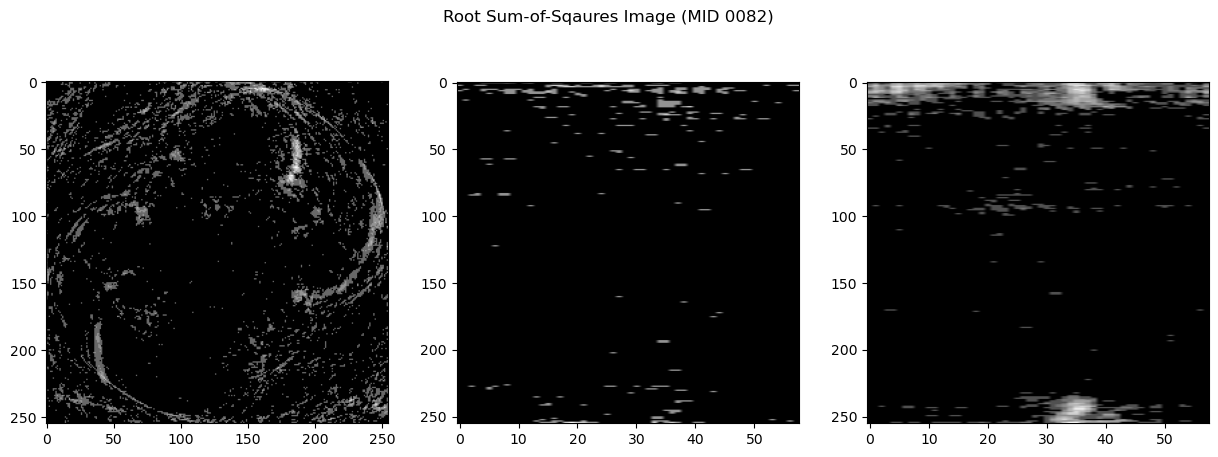

In [16]:
all_coil_imgs = np.stack(img_grid, axis=0)
img_rss = np.sqrt(np.sum(np.abs(all_coil_imgs)**2, axis=0))
fig, ax = plt.subplots(1,3, figsize=(15, 5))
aspect = 58/256
ax[0].imshow(img_rss[36, :, :], cmap='gray', aspect=1.)
ax[1].imshow(np.rot90(img_rss[:, 128, :], k=-3), cmap='gray', aspect=aspect)
ax[2].imshow(np.rot90(img_rss[:, :, 128], k=-1), cmap='gray', aspect=aspect)
fig.suptitle("Root Sum-of-Sqaures Image (MID 0082)")
plt.show()

In [ ]:
ncoils, nslices, nspokes, nsamples = ksp_data.shape
img_shape = (nslices, nsamples, nsamples)

device=1 

# Coil sensitivity
mps_shape = (ncoils, *img_shape)
mps = np.ones(mps_shape, dtype=np.complex64)

num_gates_to_reconstruct = 1 # for testing do not reconstruct all gates (takes long)
max_iter = 50 # 50 iterations for a quick check; for proper recon use max_iter=500

lam = 1e-08

output = np.zeros((*img_shape,num_gates_to_reconstruct))

for i in range(num_gates_to_reconstruct):
    with cp.cuda.Device(device=1):
        alg01 = L1WaveletRecon(data_bins[5], mps,
                                lam, coord=spoke_bins[5], device=device, coil_batch_size=3)
        result=alg01.run()
        output[...,i]=np.abs(cp.asnumpy(result))

In [ ]:
print(output[...,0].shape)
img = output[...,0]
fig, ax = plt.subplots(1,3, figsize=(15, 5))
aspect = 58/256
ax[0].imshow(img[36, :, :], cmap='gray', aspect=1.)
ax[1].imshow(np.rot90(img[:, 128, :], k=-3), cmap='gray', aspect=aspect)
ax[2].imshow(np.rot90(img[:, :, 128], k=-1), cmap='gray', aspect=aspect)
fig.suptitle("Root Sum-of-Sqaures Image (MID 0082)")
plt.show()